# <center> Feature Importance Analysis

#### 1. Data Loading 

In [1]:
# Download the Data from Google Drive
import gdown
import pandas as pd

In [7]:
# Save data to the temporary folder
merged_data_file_id = '1o_EEumVnswul9MVsrdDwBch5rt7JTr0m'
merged_data_url = f'https://drive.google.com/uc?id={merged_data_file_id}'
output = '../temporary_files/merged.csv'
gdown.download(merged_data_url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1o_EEumVnswul9MVsrdDwBch5rt7JTr0m
To: /Users/stevensong/Documents/Git_Repo/ss24-capstone-team23-datallah-nkitts-steveso/temporary_files/merged.csv
100%|██████████| 438k/438k [00:00<00:00, 5.41MB/s]


'../temporary_files/merged.csv'

In [2]:
# Load merged data into DataFrame
merged_df = pd.read_csv('../temporary_files/merged.csv')

#### 2. Correlation Analysis
Keeping too many highly correlated features can increase the complexity of the model, potentially leading to overfitting, especially if the dataset is not large enough. Simplifying the model by removing redundant features can sometimes improve generalization. 

Calcualte the Correlation Matrix and find out what features are highly correlated to ZHVI

In [3]:
# Correlation Analysis
import seaborn as sns

corr_matrix = merged_df.drop(['Date', 'City'], axis=1).corr()
ZHVI_correlation = corr_matrix.loc['ZHVI']
threshold = 0.85

mask = ZHVI_correlation > threshold
filtered_indices = ZHVI_correlation[mask].index
filtered_indices

Index(['ZHVI', 'studio', '1_bedroom', '2_bedroom', '3_bedroom', '4_bedroom'], dtype='object')

##### Interpretation of the result:
From the result above, we learned that the renting average of 'studio', '1_bedroom', '2_bedroom', '3_bedroom', '4_bedroom' are highly correlated to ZHVI. This is expected. Since our dataset is small with only ~150 monthes of data, we will remove these features to prevent overfitting.

#### 3. Permutation Importance Analysis

In [4]:
# Import packages for Feature Importance Analysis
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers  import l2
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator, RegressorMixin

In [5]:
# Preprocess the data for LSTM
def preprocess_data(df, window=12):
    split_index = int(len(df) * 0.8)
    train_df = df.iloc[:split_index]
    test_df = df.iloc[split_index:]

    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_df.drop(['Date', 'City'], axis=1))
    test_scaled = scaler.transform(test_df.drop(['Date', 'City'], axis=1))

    X_train, y_train = [], []
    for i in range(window, len(train_scaled)):
        X_train.append(train_scaled[i-window:i])
        y_train.append(train_scaled[i, 0])

    X_test, y_test = [], []
    for i in range(window, len(test_scaled)):
        X_test.append(test_scaled[i-window:i])
        y_test.append(test_scaled[i, 0])

    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test), scaler

# Custom wrapper class for Keras model
class KerasRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, build_fn, epochs=50, batch_size=32):
        self.build_fn = build_fn
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = None

    def fit(self, X, y):
        self.model = self.build_fn()
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=0)
        return self

    def predict(self, X):
        return self.model.predict(X).flatten()

# Function to create LSTM model
def create_lstm_model():
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [6]:
# Prepare data
city = 'Chicago'  # Choose a city for demonstration
city_data = merged_df[merged_df['City'] == city].reset_index(drop=True)
window_size = 3
X_train, y_train, X_test, y_test, scaler = preprocess_data(city_data, window=window_size)

# Wrap the Keras model
keras_regressor = KerasRegressor(build_fn=create_lstm_model, epochs=50, batch_size=32)
keras_regressor.fit(X_train, y_train)

# Flatten the test set for permutation importance
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Define a custom scoring function
def custom_scorer(model, X, y):
    X_reshaped = X.reshape(-1, window_size, X.shape[1] // window_size)
    y_pred = model.predict(X_reshaped).flatten()
    return -mean_squared_error(y, y_pred)  # Negate the MSE for permutation_importance compatibility

perm_importance = permutation_importance(keras_regressor, X_test_flat, y_test, n_repeats=10, random_state=0, scoring=custom_scorer)

# Plot feature importance
sorted_idx = perm_importance.importances_mean.argsort()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-08-06 16:28:51.359803: W tensorflow/core/data/root_dataset.cc:362] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


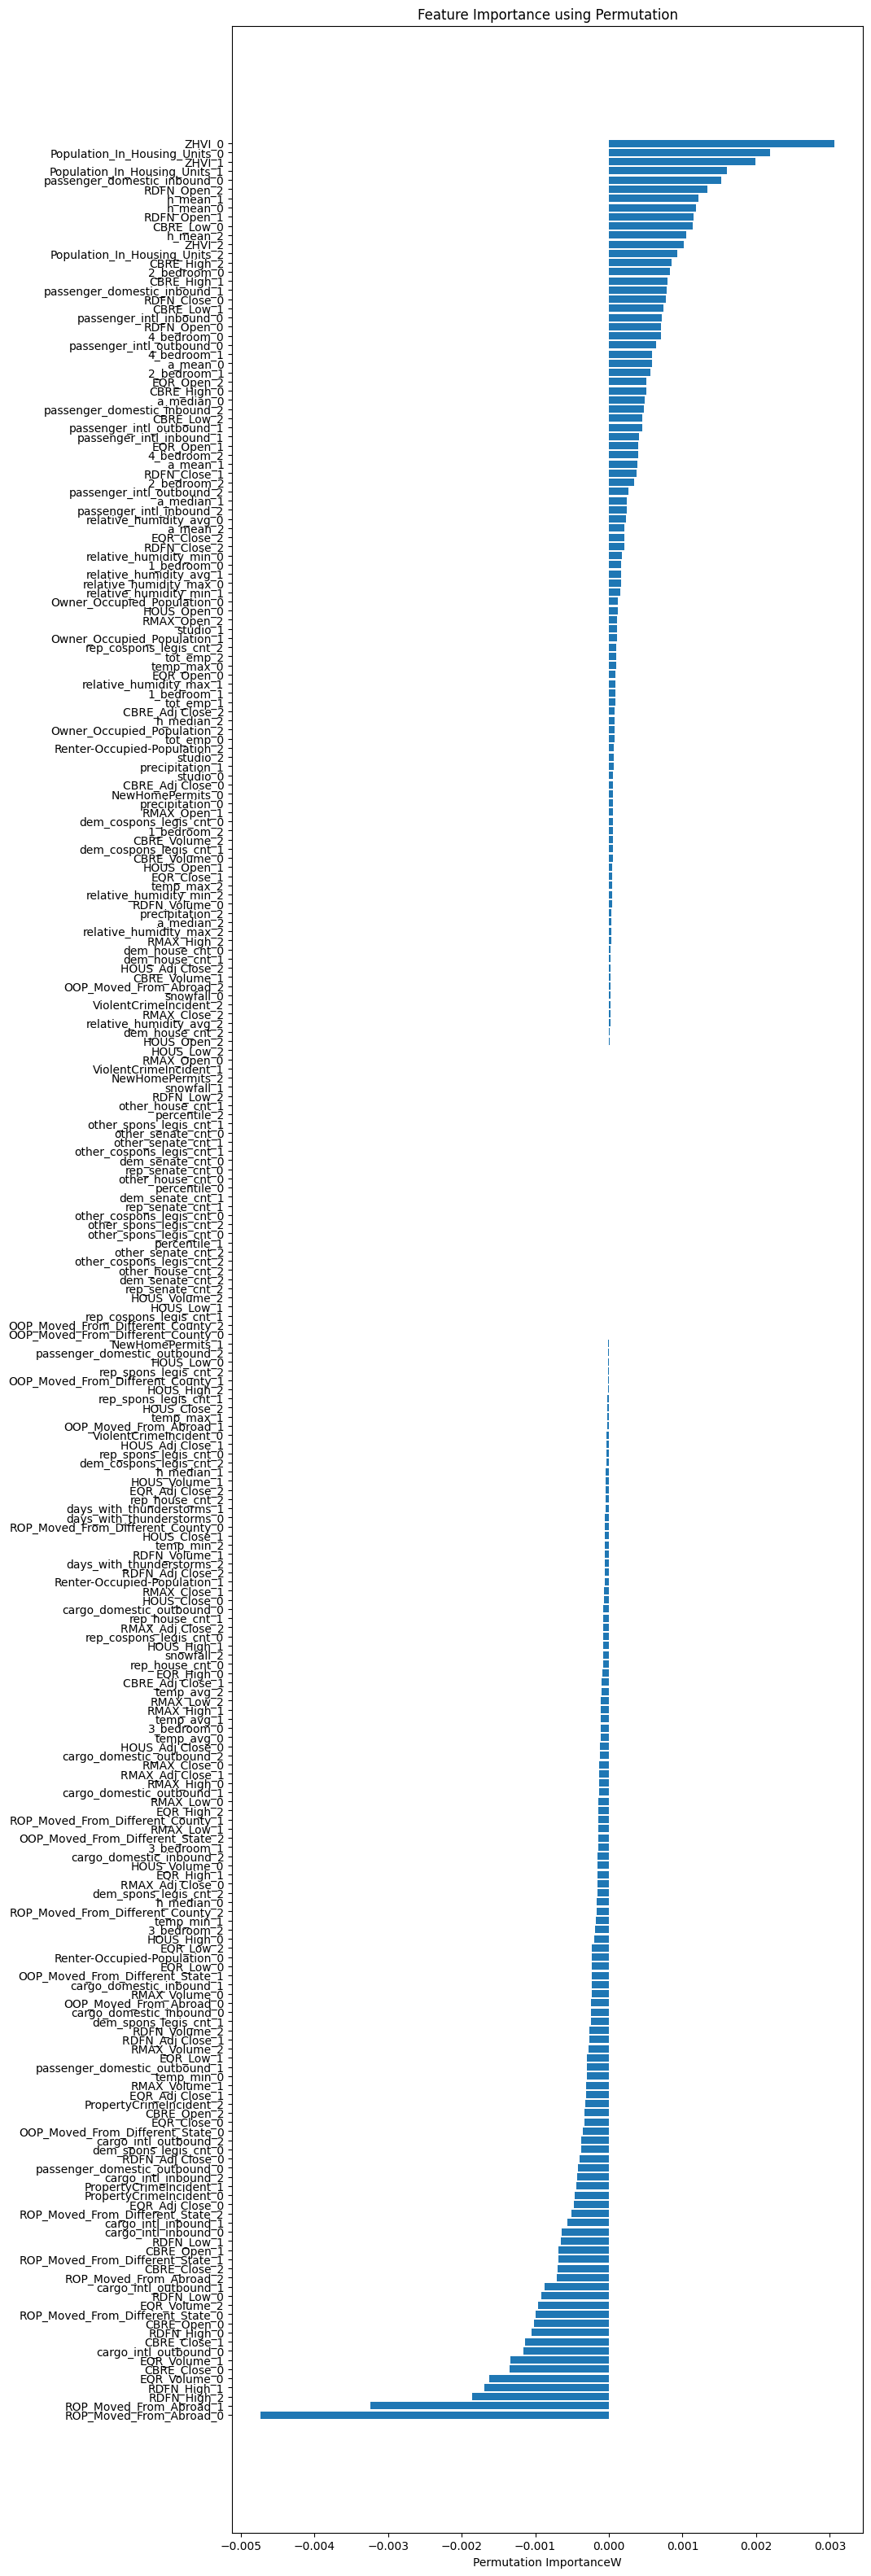

In [7]:
# Generate feature names for the flattened input
original_feature_names = city_data.columns.drop(['Date', 'City']).tolist()
feature_names = [f"{feature}_{i}" for i in range(window_size) for feature in original_feature_names]

# Plot the feature importance results
plt.figure(figsize=(10, 40)) 
plt.barh(np.array(feature_names)[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation ImportanceW")
plt.title("Feature Importance using Permutation")
plt.show()

In [54]:
# Aggregate permutation importance scores for each feature across the three windows
aggregated_importance = {}
for feature in original_feature_names:
    aggregated_importance[feature] = sum(
        perm_importance.importances_mean[i] for i in range(len(feature_names)) if feature in feature_names[i]
    )

# Get the top 3 contributing features
sorted_features = sorted(aggregated_importance.items(), key=lambda x: x[1], reverse=True)
top_10_features = sorted_features[:5]

feature_to_use = []
# Print the top 3 contributing features
print("Top 3 contributing features based on permutation importance:")
for feature, importance in top_10_features:
    print(f"{feature}: {importance}")
    feature_to_use.append(feature)

Top 3 contributing features based on permutation importance:
ZHVI: 0.006068090757350953
Population_In_Housing_Units: 0.004716406271613647
h_mean: 0.0034591120991964235
RDFN_Open: 0.0031914240943964473
passenger_domestic_inbound: 0.002793668744066835


#### 4. Check Model Performance after Feature Selection

In [55]:
requried_columns = ['City', 'Date']
selected_features = requried_columns + feature_to_use
selected_features

['City',
 'Date',
 'ZHVI',
 'Population_In_Housing_Units',
 'h_mean',
 'RDFN_Open',
 'passenger_domestic_inbound']

In [56]:
selected_features_df = merged_df[selected_features]
selected_features_df.columns

Index(['City', 'Date', 'ZHVI', 'Population_In_Housing_Units', 'h_mean',
       'RDFN_Open', 'passenger_domestic_inbound'],
      dtype='object')

In [57]:
# Function to process the data
def preprocess_data(df, window=3):
    split_index = int(len(df) * 0.8)
    train_df = df.iloc[:split_index]
    test_df = df.iloc[split_index:]

    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_df.drop(['Date', 'City'], axis=1))
    test_scaled = scaler.transform(test_df.drop(['Date', 'City'], axis=1))

    X_train, y_train = [], []
    for i in range(window, len(train_scaled)):
        X_train.append(train_scaled[i-window:i])
        y_train.append(train_scaled[i, 0])  # ZHVI is the first column

    X_test, y_test = [], []
    for i in range(window, len(test_scaled)):
        X_test.append(test_scaled[i-window:i])
        y_test.append(test_scaled[i, 0])  # ZHVI is the first column

    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test), scaler

# Function to create and train LSTM
def create_and_train_lstm(X_train, y_train, epochs=100, batch_size=32):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(units=60, return_sequences=True, kernel_regularizer=l2(0.001)))
    model.add(LSTM(units=60, return_sequences=False, kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.1)) 
    model.add(Dense(1, kernel_regularizer=l2(0.001)))
    model.compile(optimizer='adam', loss='mean_squared_error')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=10, min_lr=0.00001)
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[reduce_lr, early_stopping])

    return model, history

# Function to make predictions and inverse scale them
def make_predictions(model, X, scaler):
    predictions = model.predict(X)
    predictions = scaler.inverse_transform(np.hstack((predictions, np.zeros((predictions.shape[0], X.shape[2] - 1)))))
    return predictions[:, 0]  # Only return the ZHVI predictions

In [58]:
# Main execution
results = {}
cities = ["Chicago"]

for city in cities:
    city_data = selected_features_df[selected_features_df['City'] == city].reset_index(drop=True)
    results[city] = {}

    # Use Window size 3 as we know it's the best
    X_train, y_train, X_test, y_test, scaler = preprocess_data(city_data, window=3)

    # Train the model
    model, history = create_and_train_lstm(X_train, y_train, epochs=300, batch_size=32)

    # Make predictions
    lstm_preds = make_predictions(model, X_test, scaler)
    actual_vals = scaler.inverse_transform(np.hstack((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], X_test.shape[2] - 1)))))
    actual_vals = actual_vals[:, 0]

    # Calculate MSE
    mse = mean_squared_error(actual_vals, lstm_preds)
    results[city] = {'mse': mse, 'predictions': lstm_preds, 'actuals': actual_vals, 'history':history}
    print(f'{city} - MSE: {mse:.2f}')

Epoch 1/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.2803 - val_loss: 0.7361 - learning_rate: 0.0010
Epoch 2/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2229 - val_loss: 0.5949 - learning_rate: 0.0010
Epoch 3/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1959 - val_loss: 0.4537 - learning_rate: 0.0010
Epoch 4/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1413 - val_loss: 0.3223 - learning_rate: 0.0010
Epoch 5/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1263 - val_loss: 0.2086 - learning_rate: 0.0010
Epoch 6/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1164 - val_loss: 0.1348 - learning_rate: 0.0010
Epoch 7/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1178 - val_loss: 0.1086 - learning_rate: 0.0010
Epoch 8/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1111 - val_loss: 0.1040 - learning_rate: 0.0010
Epoch 9/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1010 - val_loss: 0.1095 - learning_rate: 0.0010
Epoch 10/300
3/3 ━━━━━━━━━━━━━━━━━━━

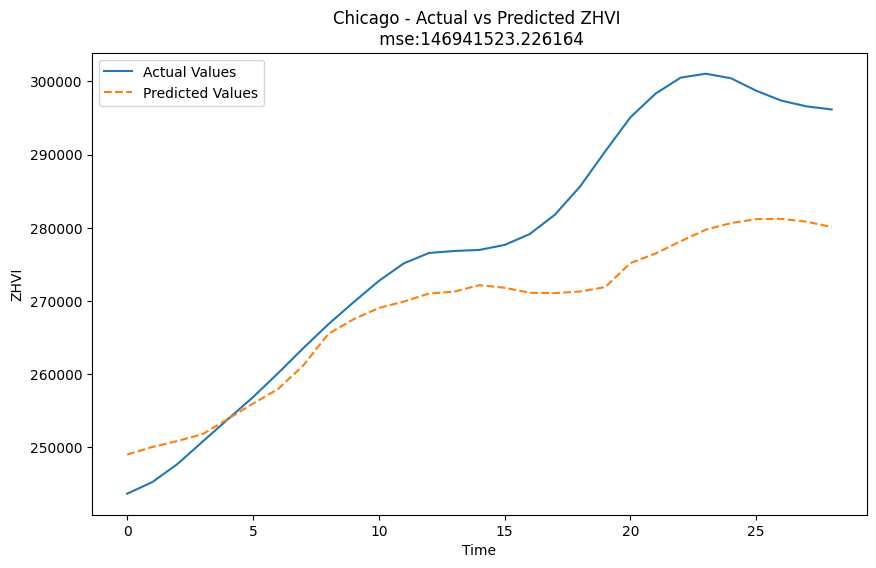

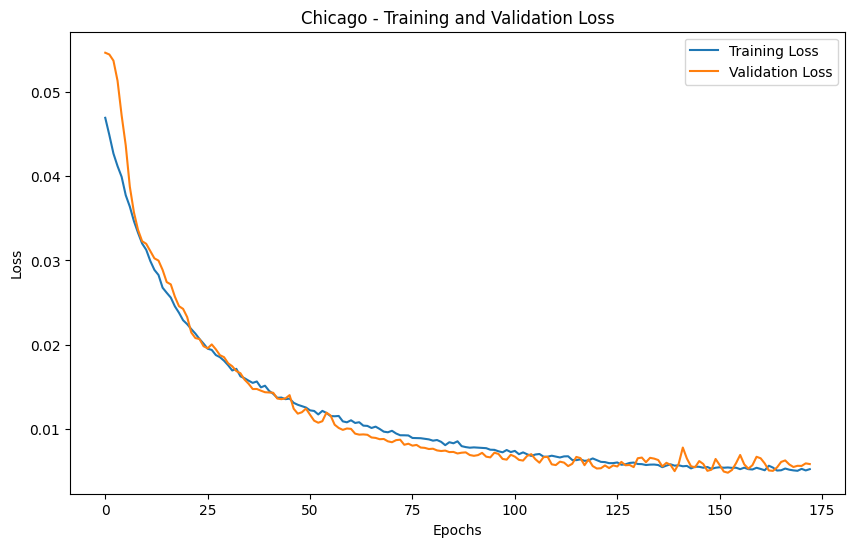

In [59]:
for idx, city in enumerate(cities):
  # Plotting the results
  plt.figure(figsize=(10, 6))
  plt.plot(results[city]['actuals'], label='Actual Values')
  plt.plot(results[city]['predictions'], label='Predicted Values', linestyle='--')
  plt.title(f"{city} - Actual vs Predicted ZHVI \n mse:{results[city]['mse']}")
  plt.xlabel('Time')
  plt.ylabel('ZHVI')
  plt.legend()
  plt.show()

  # Plotting loss curves
  plt.figure(figsize=(10, 6))
  plt.plot(results[city]['history'].history['loss'][20:], label='Training Loss')
  plt.plot(results[city]['history'].history['val_loss'][20:], label='Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.title(f"{city} - Training and Validation Loss")
  plt.show()

In [42]:
model.save('LSTM_Models/Chicago/Chicago_with_feature_selection.keras')

In [ ]:
# Compare with Mean Baseline and LSTM Baseline